In [1]:
from utils import gibbs_sampler_utils as utils

# Test on simulated data

In [2]:
# Gibbs Sampler
nb_clusters = 2
batch_size = 20
hyperparams = {'sigma0':40.,
               'alpha':1.,
               'mu0': 0.,
               'tau2': 0.5
              }
# draw data from GMM
orig_mu, orig_theta, orig_z, X = utils.gmm(nb_clusters, hyperparams, batch_size)

# estimate means and 
means, z, trace = utils.gibbs_sampler(iterations=200, nb_clusters=nb_clusters, X=X, hyperparams=hyperparams)

print('Estimated means ', means)
print('Original means ', orig_mu)
print('Estimated z ', np.argmax(z, axis=-1))
print('Original z ', orig_z)

Estimated means  [-1.2146397 -1.1532997]
Original means  [-1.3216724 -1.3094283]
Estimated z  [0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1]
Original z  [1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1]


# Test on real data: Study on Fish length distribution

The point is to see if we can distinguish between two classes of fish based on fish-length. The assumption is that tank-grown fish would have a different length distribution (i.e., mean) than wild fish. 

Two methods are tried for gmm fitting: the gibbs_sampler implemented earlier and the sklearn's GaussianMixture model (from tutorial), which uses variational autoencoder for inference. 

Different parameters were tried for gibbs_sampler(). The ones reported gave the best fit.

The means estimated by gibbs_sampler() and sklearn's GMM do not differ by much. This is a positive evaluation of gibbs_sampler().


In [3]:
import pandas as pd
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
import seaborn

           Tyyppi      Taimen  TyyppiTaimen  Allastoisto       Allas  \
count  241.000000  241.000000    241.000000   241.000000  241.000000   
mean     1.331950    1.551867      2.887967     1.510373  820.676349   
std      0.471893    0.498337      1.106750     0.500933    2.621033   
min      1.000000    1.000000      1.000000     1.000000  817.000000   
25%      1.000000    1.000000      2.000000     1.000000  818.000000   
50%      1.000000    2.000000      3.000000     2.000000  821.000000   
75%      2.000000    2.000000      4.000000     2.000000  823.000000   
max      2.000000    2.000000      4.000000     2.000000  824.000000   

           Pituus       Paino   Condition  
count  241.000000  241.000000  241.000000  
mean   132.709544   27.641909    0.822394  
std     22.483296   17.972593    0.206725  
min     88.000000    5.200000    0.375761  
25%    110.000000    9.200000    0.607839  
50%    135.000000   28.400000    0.914540  
75%    150.000000   39.000000    0.979346  

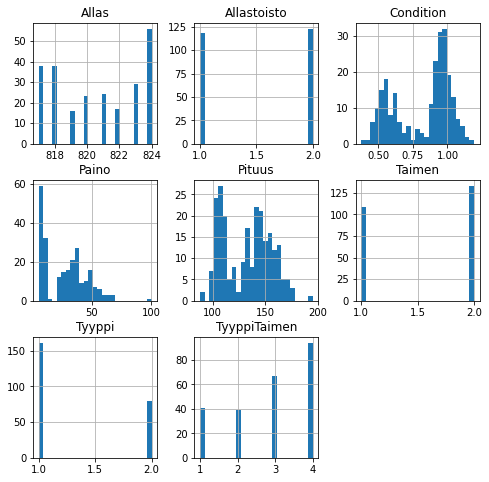

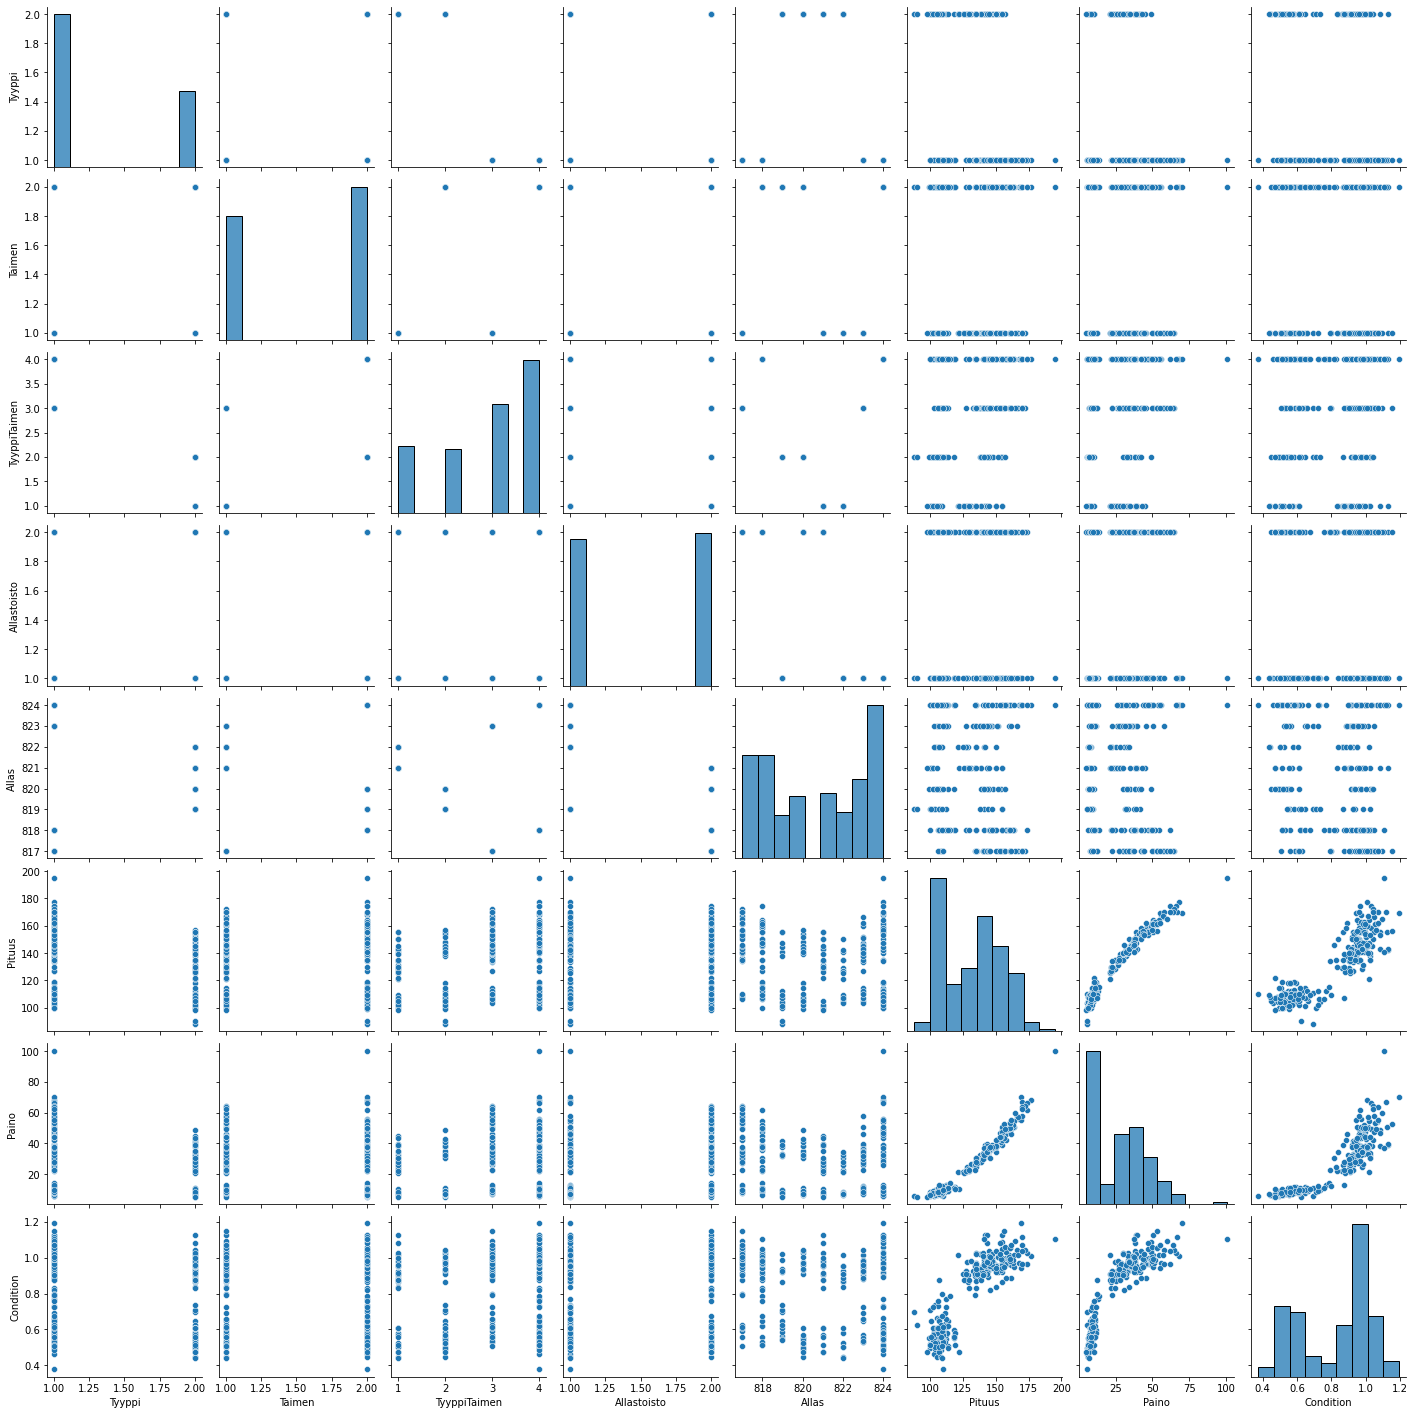

In [6]:
# preprocessing
fish = pd.read_csv('data/fish_data.txt', sep=';', decimal=',',  encoding = "utf-8")

# remove all column that contain NaN values
ids = fish.apply(lambda x: np.all(x.notna()), axis=0)
fish = fish.iloc[:, ids.tolist()]
# we only take sample with "MITTAUSAIKA" = "LOPETUS"
selected_row = fish.MITTAUSAIKA == "LOPETUS"
fish = fish[selected_row]
print(fish.describe())

_ = fish.hist(figsize=(8, 8), bins=25)
_ = seaborn.pairplot(fish)

In [7]:
# ====== Getting the tank and fish length data ====== #
# Pituus: length
# Paino : weight
data = fish[['Allas', 'Pituus']]

hyperparams = {'sigma0':10.,
               'mu0': 120,
               'tau2': 5.
              }

# ====== grouping the data by the Tank ====== #
n_components = 2
# selecting random color for each component
colors = seaborn.color_palette(
    palette='Set2', n_colors=n_components)
# we need this to draw Gaussian distribution

for pool_id in data.Allas.unique():
    # select all data from given tank
    pool_data = data.Pituus[data.Allas == pool_id]
    means = utils.gibbs_sampler(iterations=50, nb_clusters=2, X=pool_data.to_numpy(), hyperparams=hyperparams)[0]
    
    print("means for pool %d are: %.2f, %2.f" % (pool_id, means[0], means[1]))
    

means for pool 819 are: 103.90, 145
means for pool 824 are: 155.72, 109
means for pool 823 are: 111.76, 144
means for pool 820 are: 107.05, 145
means for pool 822 are: 134.12, 109
means for pool 821 are: 137.64, 102
means for pool 818 are: 114.25, 152
means for pool 817 are: 108.71, 152


In [10]:
# ====== Getting the tank and fish length data ====== #
# Pituus: length
# Paino : weight
data = fish[['Allas', 'Pituus']]

# ====== grouping the data by the Tank ====== #

n_components = 2
# selecting random color for each component
colors = seaborn.color_palette(
    palette='Set2', n_colors=n_components)
# we need this to draw Gaussian distribution

for pool_id in data.Allas.unique():
    # select all data from given tank
    pool_data = data.Pituus[data.Allas == pool_id]

    # Fitting Gaussian on Pool data
    GMM = GaussianMixture(n_components=int(n_components),
                        covariance_type='diag', n_init=8,
                        random_state=5218)

    # the input data must be at least 2D, so we
    # need to do some preprocessing
    pool_data = np.atleast_2d(pool_data.values).T
    GMM.fit(pool_data)

    # Visualizing the GMM
    mean = GMM.means_.ravel()
    print("means for pool %d are: %.2f, %2.f" % (pool_id, mean[0], mean[1]))
    

means for pool 819 are: 102.10, 147
means for pool 824 are: 108.85, 156
means for pool 823 are: 109.49, 144
means for pool 820 are: 146.40, 107
means for pool 822 are: 133.08, 106
means for pool 821 are: 101.33, 138
means for pool 818 are: 151.13, 112
means for pool 817 are: 151.99, 108
